In [12]:
import math
import matplotlib.pyplot as plt
import heapq

from src.signal_generator import SignalGenerator
from src.metrics import Metric
from src.data_type import Measurement


{'original_size': 100, 'compressed_size': 20, 'compression_rate': 0.8}


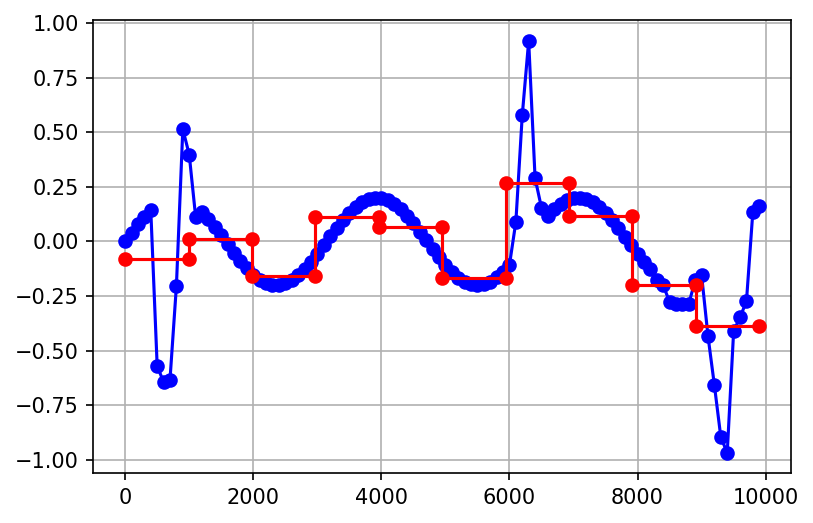

{'original_size': 100, 'compressed_size': 20, 'compression_rate': 0.8}


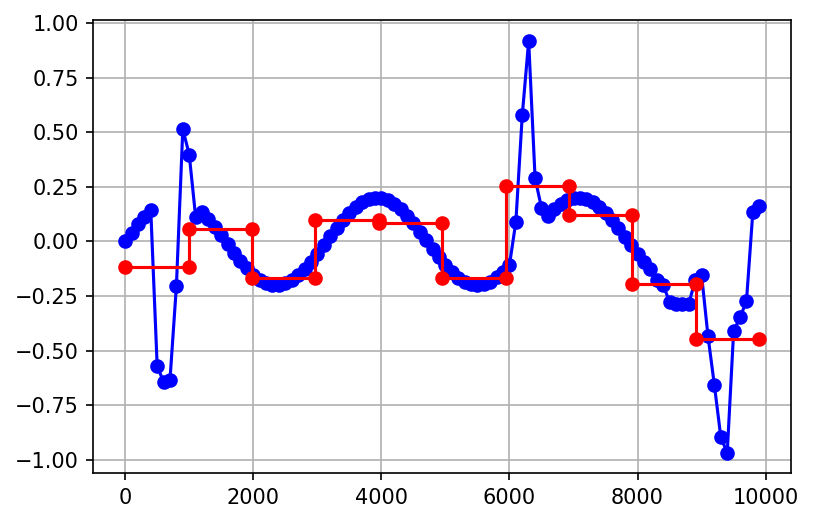

In [60]:
class DataCompressor:
  metric: Metric = Metric()
  original_data: list[Measurement] = []
  compressed_data: list[Measurement] = []

  # paper
  # PIP-PD - perceptual interesting points - perpendicular distance
  # 10.1.1.672.9655.pdf
  def compress_pip_pd(self): 
    # todo
    pass

  # paper
  # PIP-VD - perceptual interesting points - vertical distance
  # 10.1.1.672.9655.pdf
  def compress_pip_vd(self): 
    # todo
    pass

  # paper
  # ZIP - Zigzag-perceptually important point
  # 10.1.1.672.9655.pdf
  def compress_pip_vd(self): 
    # todo
    pass

  # paper
  # PAA - Piecewise Aggregate Approximation
  # kais_2000.pdf
  def compress_paa(self):
    # todo
    pass

  # paper
  # SVD - Singular Value Decomposition
  # 10.1.1.121.7455.pdf
  def compress_svd():
    pass

  # paper
  # DWT - Discrete Wavelets Transform
  # wavelet.pdf
  def compress_dwt():
    pass

  # paper
  # DFT - Discrete Fourier Transform
  # 
  def compress_dft():
    pass

  # paper
  # PFR - Peak Focus Reduction
  # 10.1.1.462.5253.pdf
  def compress_dft():
    pass

  # paper
  # A-ISR - Adaptable Interzone Sampling Reduction
  # 10.1.1.462.5253.pdf
  def compress_dft():
    pass

  # paper
  # TP - Turning points
  # OBST2013.pdf
  def compress_dft():
    pass

  # paper
  # RWA - Random Walk Algorithm
  # 
  def compress_rwa():
    pass

  # paper
  # MVA - Mean Value Algorithm
  # 
  def compress_mva():
    pass

  # paper
  # HSR - Height Sorting Reduction
  # 
  def compress_hsr():
    pass

  # paper
  # ASR - Angle Sorting Reduction
  # 
  def compress_asr():
    pass

  # paper
  # ACAP - 
  # 
  def compress_asr():
    pass

  # paper
  # SWING
  # energies-12-02523-v3.pdf
  def compress_swing():
    pass

  # custom

  def compress_stc_v2(self):
    # todo
    # nie brać tylko dwóch pod uwagę a dłuższe ramie
    pass

  def compress_random(self):
    # todo
    pass

  def compress_with_density(self):
    # todo
    pass

  def compress_with_corelation(self):
    # todo
    pass

  def compress_minimum_for_metric(self):
    # todo
    pass

  def push(self, measurement: Measurement):
    self.original_data.append(measurement)
  
  def set_data(self, measurements: list[Measurement]):
    self.original_data = measurements

  def clean_data(self):
    self.original_data = []
    self.compressed_data = []

  def vizualize(self, show_compressed: bool = True, show_interpolation: bool = False):
    x_original = [measurement.timestamp for measurement in self.original_data]
    y_original = [measurement.value for measurement in self.original_data]
    plt.figure(dpi=150)
    if show_interpolation:
        plt.plot(x_original, y_original, 'b')
    plt.plot(x_original, y_original, 'bo')
    if show_compressed:
      x_compressed = [measurement.timestamp for measurement in self.compressed_data]
      y_compressed = [measurement.value for measurement in self.compressed_data]
      if show_interpolation:
        plt.plot(x_compressed, y_compressed, 'r')
      plt.plot(x_compressed, y_compressed, 'ro')
    plt.grid()
    plt.show()
    return self

  def get_data(self):
    return [measurement.value for measurement in self.compressed_data]

  def get_stats(self):
    return {
      'original_size': len(self.original_data),
      'compressed_size': len(self.compressed_data),
      'compression_rate': (len(self.original_data) - len(self.compressed_data)) / len(self.original_data)
    }

  # paper
  # PPA - Piecewise Polynomial Approximation
  # kais_2000.pdf https://jmotif.github.io/sax-vsm_site/morea/algorithm/PAA.html
  def compress_ppa():
    pass

  # paper
  # PLR - Piecewise Linear Representation
  # pkdd99keogh_pazzani.pdf
  def compress_plr(self):
    pass

  config = {
    'chunk_count': 10,
    'compress_ratio': 0.5,
  }

  def interpolate_value(self, x: int, point_A: Measurement, point_B: Measurement) -> float:
    return ((point_B.value - point_A.value) / (point_B.timestamp - point_A.timestamp)) * x \
      + ((point_B.timestamp * point_A.value - point_A.timestamp * point_B.value) / (point_B.timestamp - point_A.timestamp))

  # paa
  def compress(self):
    data_size = len(self.original_data)
    if data_size < 2:
      self.compressed_data = self.original_data[:]
      return
    chunk_count = self.config['chunk_count']
    if not chunk_count:
      chunk_count = data_size * self.config['compress_ratio']
    x_first = self.original_data[0].timestamp
    x_last = self.original_data[data_size - 1].timestamp

    chunk_size = (x_last - x_first) / chunk_count
    points_per_chunk = int(data_size / chunk_count)
    step_size = chunk_size / points_per_chunk

    series = []
    stop = False
    current_x = x_first
    last_checked_index = 1
    for _ in range(chunk_count):
      current_series = []
      for _ in range(points_per_chunk):
        current_x += step_size
        while current_x > self.original_data[last_checked_index].timestamp:
          last_checked_index += 1
          if last_checked_index >= data_size:
            stop = True
            break
        if stop:
          break
        point_a = self.original_data[last_checked_index - 1]
        point_b = self.original_data[last_checked_index]
        computed_value = self.interpolate_value(current_x, point_a, point_b)
        current_series.append(computed_value)
      if stop:
        break
      series.append(current_series)

    for i, line in enumerate(series):
      value = sum(line) / len(line)
      self.compressed_data.append(Measurement(value, i * chunk_size))
      self.compressed_data.append(Measurement(value, (i + 1) * chunk_size))

  # paa
  def compress2(self):
    data_size = len(self.original_data)
    if data_size < 2:
      self.compressed_data = self.original_data[:]
      return
    chunk_count = self.config['chunk_count']
    if not chunk_count:
      chunk_count = data_size * self.config['compress_ratio']
    x_first = self.original_data[0].timestamp
    x_last = self.original_data[data_size - 1].timestamp
    chunk_size = (x_last - x_first) / chunk_count

    series = []
    stop = False
    last_checked_index = 0
    for i in range(chunk_count):
      current_series = []
      while (i + 1) * chunk_size > self.original_data[last_checked_index].timestamp:
        current_series.append(self.original_data[last_checked_index].value)
        last_checked_index += 1
        if last_checked_index >= data_size:
            stop = True
            break
      if len(current_series) > 0:
        series.append(sum(current_series) / len(current_series))
      if stop:
        break

    for i, value in enumerate(series):
      self.compressed_data.append(Measurement(value, i * chunk_size))
      self.compressed_data.append(Measurement(value, (i + 1) * chunk_size))

signal_generator = SignalGenerator(0, 100).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2)
data_compressor = DataCompressor()

for index, measurement in enumerate(signal_generator.data):
  data_compressor.push(Measurement(measurement, index * 100))
# data_compressor.set_data([Measurement(i, i*100) for i in range(20)])
data_compressor.compress()
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)

data_compressor.compressed_data = []

data_compressor.compress2()
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)

In [ ]:
import unittest
from tests_.basic import *

unittest.main(argv=[''], verbosity=2, exit=False)

test_isupper (tests_.basic.TestStringMethods) ... ok
test_split (tests_.basic.TestStringMethods) ... ok
test_upper (tests_.basic.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


In [ ]:
class DataCompressor:
  metric: Metric = Metric()
  original_data: list[Measurement] = []
  compressed_data: list[Measurement] = []

  config = {
    
  }

  # paper
  # PIP-PD - perceptual interesting points - perpendicular distance
  # 10.1.1.672.9655.pdf
  def compress_pip_pd(self): 
    # todo
    pass

  # paper
  # PIP-VD - perceptual interesting points - vertical distance
  # 10.1.1.672.9655.pdf
  def compress_pip_vd(self): 
    # todo
    pass

  # paper
  # ZIP - Zigzag-perceptually important point
  # 10.1.1.672.9655.pdf
  def compress_pip_vd(self): 
    # todo
    pass

  # paper
  # PAA - Piecewise Aggregate Approximation
  # kais_2000.pdf
  def compress_paa(self):
    # todo
    pass

  # paper
  # PLR - Piecewise Linear Representation
  # pkdd99keogh_pazzani.pdf
  def compress_plr(self):
    pass

  # paper
  # SVD - Singular Value Decomposition
  # 10.1.1.121.7455.pdf
  def compress_svd():
    pass

  # paper
  # DWT - Discrete Wavelets Transform
  # wavelet.pdf
  def compress_dwt():
    pass

  # paper
  # DFT - Discrete Fourier Transform
  # 
  def compress_dft():
    pass

  # paper
  # PFR - Peak Focus Reduction
  # 10.1.1.462.5253.pdf
  def compress_dft():
    pass

  # paper
  # A-ISR - Adaptable Interzone Sampling Reduction
  # 10.1.1.462.5253.pdf
  def compress_dft():
    pass

  # paper
  # TP - Turning points
  # OBST2013.pdf
  def compress_dft():
    pass

  # paper
  # RWA - Random Walk Algorithm
  # 
  def compress_rwa():
    pass

  # paper
  # MVA - Mean Value Algorithm
  # 
  def compress_mva():
    pass

  # paper
  # HSR - Height Sorting Reduction
  # 
  def compress_hsr():
    pass

  # paper
  # ASR - Angle Sorting Reduction
  # 
  def compress_asr():
    pass

  # paper
  # ACAP - 
  # 
  def compress_asr():
    pass

  # paper
  # PPA - Piecewise Polynomial Approximation
  # 
  def compress_ppa():
    pass

  # paper
  # SWING
  # energies-12-02523-v3.pdf
  def compress_swing():
    pass

  # custom

  def compress_stc_v2(self):
    # todo
    # nie brać tylko dwóch pod uwagę a dłuższe ramie
    pass

  def compress_random(self):
    # todo
    pass

  def compress_with_density(self):
    # todo
    pass

  def compress_with_corelation(self):
    # todo
    pass

  def compress_minimum_for_metric(self):
    # todo
    pass

  def compress(self):
    # todo: check metrics
    # self.()
    pass

  def push(self, measurement: Measurement):
    self.original_data.append(measurement)
  
  def set_data(self, measurements: list[Measurement]):
    self.original_data = measurements

  def clean_data(self):
    self.original_data = []
    self.compressed_data = []

  def vizualize(self, show_compressed: bool = True, show_interpolation: bool = False):
    x_original = [measurement.timestamp for measurement in self.original_data]
    y_original = [measurement.value for measurement in self.original_data]
    plt.figure(dpi=150)
    if show_interpolation:
        plt.plot(x_original, y_original, 'b')
    plt.plot(x_original, y_original, 'bo')
    if show_compressed:
      x_compressed = [measurement.timestamp for measurement in self.compressed_data]
      y_compressed = [measurement.value for measurement in self.compressed_data]
      if show_interpolation:
        plt.plot(x_compressed, y_compressed, 'r')
      plt.plot(x_compressed, y_compressed, 'ro')
    plt.grid()
    plt.show()
    return self

  def get_data(self):
    return [measurement.value for measurement in self.compressed_data]

  def get_stats(self):
    return {
      'original_size': len(self.original_data),
      'compressed_size': len(self.compressed_data),
      'compression_rate': (len(self.original_data) - len(self.compressed_data)) / len(self.original_data)
    }

signal_generator = SignalGenerator(0, 100).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2)
# signal_generator = SignalGenerator(0, 100).sin(5, 0.2).noise()
# signal_generator = SignalGenerator(0, 100).with_peaks(3)
# signal_generator.draw()
data_compressor = DataCompressor()

for index, measurement in enumerate(signal_generator.data):
  data_compressor.push(Measurement(measurement, index * 100))
# data_compressor.set_data([Measurement(i, i*100) for i in range(20)])
data_compressor.compress()
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)